# Compile Catalogs

In [2]:
#from astroquery.gaia import Gaia
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy.table import Table
import numpy as np
from astropy.io.ascii import read

## Import Catalogs

In [3]:
# Open the GCNS catalog
# Parse using the ReadMe:
gcns = read('/datax/scratch/emmay/GCNS/table1c.dat', format='cds', readme='/datax/scratch/emmay/GCNS/ReadMe')

In [4]:
# Open the Gaia-ESO file
hdulist = fits.open('/datax/scratch/emmay/GaiaESO/result_ervvfchjzcb7sbg9.fits')

# === Read the catalog table ===
# The PHASE3CATALOG is the second HDU (index 1)
catalog_hdu = hdulist[1]

# Get the data as a table
GaiaESO = catalog_hdu.data

type(GaiaESO)

astropy.io.fits.fitsrec.FITS_rec

In [5]:
type(gcns)

astropy.table.table.Table

## Some Sanity Checks
Comparing with https://github.com/jradavenport/spectro100/blob/main/gathering%20data.ipynb

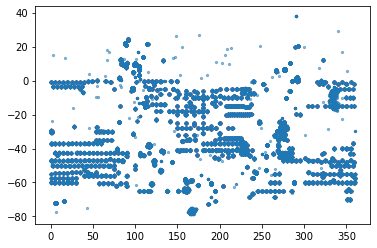

In [6]:
# Sanity check of RA vs DEC plot compared to Jim's
plt.figure()
plt.scatter(GaiaESO['RA'], GaiaESO['DECLINATION'], s=5, alpha=0.5)

In [7]:
GCNS_C = SkyCoord(ra=gcns['RAdeg'], dec=gcns['DEdeg'], frame='icrs')
GaiaESO_C = SkyCoord(ra=GaiaESO['RA']*u.degree, dec=GaiaESO['DECLINATION']*u.degree)


In [8]:
# Again, good sanity check - matches with what Jim got
Gdx = GCNS_C.match_to_catalog_sky(GaiaESO_C)
Gmtch = Gdx[0][Gdx[1].to('arcsec').value < 5]
print(sum(Gdx[1].to('arcsec').value < 5))

147


## Crossmatching with GCNS

In [ ]:
# 1) Use match_to_catalog_sky 
idx, d2d, _ = GCNS_C.match_to_catalog_sky(GaiaESO_C)

# 2) Limit to matches within 2 arcsec
matches = d2d < 2 * u.arcsec

# 3) Prepare arrays
is_in_GaiaESO = np.zeros(len(gcns), dtype=int)
GaiaESO_name = np.full(len(gcns), np.nan, dtype=object)

# 4) Fill only for matched rows
is_in_GaiaESO[matches] = 1
GaiaESO_name[matches] = GaiaESO['OBJECT'][idx[matches]]

# 5) Store in new copy
catalog_summary = gcns.copy()
catalog_summary['is_in_GaiaESO'] = is_in_GaiaESO
catalog_summary['GaiaESO_name'] = GaiaESO_name

In [17]:
columns_of_interest = ["GaiaEDR3", "RAdeg", "DEdeg", "is_in_GaiaESO", "GaiaESO_name"]
catalog_summary[catalog_summary['is_in_GaiaESO']==1][columns_of_interest]

GaiaEDR3,RAdeg,DEdeg,is_in_GaiaESO,GaiaESO_name
,deg,deg,,
int64,float64,float64,int64,object
2336728947968831104,1.8871494,-23.8183163,1,00073283-2349062
2445242288839432704,2.5260238,-3.3400922,1,00100625-0320247
4918806107423681920,4.6915643,-57.6499893,1,00184592-5738599
2528577058247110784,7.5079263,-3.4888476,1,00300188-0329196
5001454888951528704,15.0923768,-36.9642585,1,01002215-3657513
2584834502690477312,16.5533881,13.2526955,1,01061278+1315096
2531223307857060096,17.7622438,-3.5432802,1,01110292-0332351
4983718632524887936,19.7219476,-42.460977,1,01185326-4227395


In [11]:
gcns.columns

<TableColumns names=('GaiaEDR3','RAdeg','e_RAdeg','DEdeg','e_DEdeg','Plx','e_Plx','pmRA','e_pmRA','pmDE','e_pmDE','Gmag','RFG','BPmag','RFBP','RPmag','RFRP','E(BP/RP)','RUWE','IPDfmp','RV','e_RV','r_RV','f_RV','GCNSprob','WDprob','Dist1','Dist16','Dist50','Dist84','xcoord50','xcoord16','xcoord84','ycoord50','ycoord16','ycoord84','zcoord50','zcoord16','zcoord84','Uvel50','Uvel16','Uvel84','Vvel50','Vvel16','Vvel84','Wvel50','Wvel16','Wvel84','GUNN','r_GUNN','gmag','e_gmag','rmag','e_rmag','imag','e_imag','zmag','e_zmag','2MASS','Jmag','e_Jmag','Hmag','e_Hmag','Ksmag','e_Ksmag','WISE','W1mag','e_W1mag','W2mag','e_W2mag','W3mag','e_W3mag','W4mag','e_W4mag')>